# Markov Chain

In [1]:
import numpy as np
import copy
import math
import string
import matplotlib.pyplot as plt
import csv

In [2]:
class MarkovChain:
    markov_matrix: np.ndarray
    absorbing_state: np.ndarray
    states: list

    def __init__(self, absorbing_state: np.ndarray, length_of_case: int, num_of_character: int):
        self.absorbing_state = absorbing_state
        self.length_of_case = length_of_case
        self.num_of_characters = num_of_character

        self.markov_matrix = np.ndarray(shape=(0, self.length_of_case + 1))

        self.states = self.create_individual_states()
        self.generate_markov_matrix()

    def create_individual_states(self) -> list:
        state_collection = []
        for i in range(self.length_of_case + 1):
            # print(self.absorbing_state[:i])
            state_collection.append(self.absorbing_state[:i])

        return state_collection

    def generate_markov_matrix(self) -> None:
        for i in range(self.length_of_case):
            prob = self.state_transition_probability(self.states[i])
            # print("State No. ", i,": ", self.states[i], " ", prob)
            self.markov_matrix = np.insert(self.markov_matrix, i, [prob], axis=0)

    def state_transition_probability(self, current_state: np.ndarray) -> np.ndarray:
        state = copy.deepcopy(current_state)
        probability = np.zeros(self.length_of_case + 1)

        for i in range(self.num_of_characters):
            if state.size + 1 <= self.absorbing_state.size and i == self.absorbing_state[state.size]:
                probability[state.size + 1] += 1
            else:
                state = np.append(state, i)

                reduced = self.reduce_state(state)
                probability[reduced.size] += 1

                state = np.delete(state, -1)

        return probability

    def reduce_state(self, state: np.ndarray) -> np.ndarray:
        reduced = copy.deepcopy(state)
        size: int

        while True:
            size = reduced.size
            for i in range(reduced.size):
                if reduced[i] != self.absorbing_state[i]:
                    if i == 0:
                        reduced = np.delete(reduced, 0)
                    else:
                        for j in range(i):
                            reduced = np.delete(reduced, 0)
                    break

            if size == reduced.size:
                break

        return reduced

    def get_markov_matrix(self) -> np.ndarray:
        matrix = np.ndarray(shape=(self.length_of_case + 1, self.length_of_case + 1))

        for i in range(self.length_of_case):
            for j in range(self.length_of_case + 1):
                matrix[i][j] = float(self.markov_matrix[i][j] / self.num_of_characters)

        for i in range(self.length_of_case):
            matrix[self.length_of_case][i] = 0.0

        matrix[self.length_of_case][self.length_of_case] = 1.0

        return matrix

In [3]:
class ExpectedValue:
    number_of_character: int
    length_of_case: int
    markov_chains: list[MarkovChain]
    expected_values: list[float]

    def __init__(self, num_of_chars: int, length_of_case: int):
        self.number_of_character = num_of_chars
        self.length_of_case = length_of_case

        self.get_markov_chains()
        self.get_expected_values()

    def get_markov_chains(self):
        self.markov_chains = []
        for i in range(int(math.pow(self.number_of_character, self.length_of_case))):
            result = convert_base(i, self.number_of_character)
            absorbing_state = np.array([])
            for j in range(self.length_of_case - len(result)):
                absorbing_state = np.append(absorbing_state, 0)
            for j in range(len(result)):
                if 48 <= ord(result[j]) <= 57:
                    absorbing_state = np.append(absorbing_state, int(result[j]))
                else:
                    absorbing_state = np.append(absorbing_state, int(ord(result[j]) - 87))

            markov = MarkovChain(absorbing_state=absorbing_state, num_of_character=self.number_of_character, length_of_case=self.length_of_case)
            self.markov_chains.append(markov)

    def get_expected_values(self):
        self.expected_values = []
        for i in range(len(self.markov_chains)):
            markov_matrix = self.markov_chains[i].get_markov_matrix()
            fundamental_matrix = np.ndarray(shape=(0, self.length_of_case))
            for j in range(self.length_of_case):
                fundamental_matrix = np.insert(fundamental_matrix, j, markov_matrix[j, :-1], 0)

            difference = np.eye(self.length_of_case) - fundamental_matrix

            inverse = np.linalg.inv(difference)
            expected_value = 0.0
            for j in range(self.length_of_case):
                expected_value += inverse[0, j]

            self.expected_values.append(round(expected_value))

    def get_info(self):
        # record_on_csv(self.number_of_character, self.length_of_case, self.markov_chains, self.expected_values)
        graph_expected_value_data(self)

In [4]:
tmp = string.digits + string.ascii_lowercase

def convert_base(num: int, base: int):
    q, r = divmod(num, base)
    if q == 0:
        return tmp[r]
    else:
        return convert_base(q, base) + tmp[r]
    
def add_labels(x, y):
    for i in range(len(x)):
        plt.text(i, y[i]*1.02, y[i], ha= 'center')
        
def record_on_txt(number_of_characters: str, length_of_case: str, markov_chains: list[MarkovChain], expected_values: list[float]) -> None:
    with open("markov_chain_results.txt", "a") as function:
        function.writelines("Expected Values for when m: " + number_of_characters + ", n: " + length_of_case + "\n\n")
        for i in range(len(expected_values)):
            record = "E(X) for case " + str(markov_chains[i].absorbing_state) + " : " + str(expected_values[i])
            function.writelines(record + "\n")
        function.writelines("\n--------------------\n\n")
        
def record_on_csv(number_of_characters: int, length_of_case: int, markov_chains: list[MarkovChain], expected_values: list[float]) -> None:
    with open("markov_chain_results_4.csv", mode="a") as csv_writer:
        field_name = ['number_of_characters', 'length_of_case', 'absorbing_state', 'expected_value']
        dictionary_writer = csv.DictWriter(csv_writer, fieldnames=field_name, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        if number_of_characters == 1 and length_of_case == 1:
            dictionary_writer.writeheader()
        else:
            for i in range(len(expected_values)):
                dictionary_writer.writerow(
                    {
                        'number_of_characters': number_of_characters, 
                        'length_of_case': length_of_case, 
                        'absorbing_state': markov_chains[i].absorbing_state, 
                        'expected_value': expected_values[i]
                    }
                )
    
def graph_expected_value_data(expected_values: ExpectedValue):
    expected_value_list = expected_values.expected_values
    absorbing_state = []
    
    for i in range(len(expected_values.markov_chains)):
        absorbing_state.append(np.array2string(expected_values.markov_chains[i].absorbing_state))
        
    plt.figure(
        figsize=(
            1.2 * int(math.pow(expected_values.number_of_character, expected_values.length_of_case)), 
            0.45 * int(math.pow(expected_values.number_of_character, expected_values.length_of_case))
        )
    )
    
    plt.rcParams['font.family'] = ['monospace']
    plt.rcParams['font.size'] = 20.0
    plt.rcParams['font.weight'] = 800
    
    plt.bar(absorbing_state, expected_value_list, color= 'orange', edgecolor='red')
    add_labels(absorbing_state, expected_value_list)
    
    plt.title('Expected Values for m: ' + str(expected_values.number_of_character) + ", n: " + str(expected_values.length_of_case))
    plt.xlabel('Absorbing States')
    plt.ylabel('Expected Values')
    plt.xticks(rotation= 45, ha='right')
    plt.show()

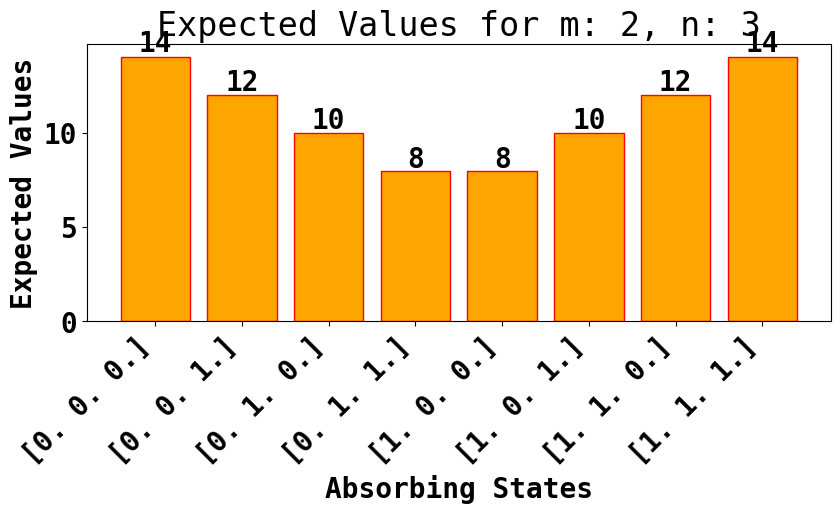

In [5]:
def main():
    # markov1 = MarkovChain(absorbing_state=np.array([0, 1, 2, 2, 0, 1]), length_of_case=6, num_of_character=5)
    # markov2 = MarkovChain(absorbing_state=np.array([0, 1, 2, 2, 0, 2]), length_of_case=6, num_of_character=5)
    # print(markov1.get_markov_matrix(), end="\n\n")
    # print(markov2.get_markov_matrix(), end="\n\n")
    m = int(input("Number of Characters: "))
    n = int(input("Length of Cases: "))

    expected_value = ExpectedValue(num_of_chars=m, length_of_case=n)
    expected_value.get_info()
    # graph_expected_value_data(expected_values=expected_value)
    return 0


if __name__ == '__main__':
    main()